# Optimizing Revenue from the Demand Curve

The demand curve is usually defined as a plot of demand/quantity (y-axis), $Q$, against the price (x-axis), $P$. For nearly all products, as $P$ goes up then $Q$ comes down. We can model the demand curve (linearly or non-linearly) to figure out how $P$ and $Q$ are related, and use this relationship to find the "optimal" price that will maximize revenue. Let's see how computing the optimal price from a demand curve works.

## Simulated data

Let's simulate some data for $P$ and $Q$.

- $P \sim \mathcal{N}(10, 1)$
- $Q \sim \mathcal{N}(100 - 2.5 P, 1)$

In [1]:
import pandas as pd
import numpy as np

np.random.seed(37)

N = 100
P = np.random.normal(10, 1, N)
Q = np.random.normal(100 - (2.5 * P), 1, N)

df = pd.DataFrame({'p': P, 'q': Q}) \
    .sort_values(['p']) \
    .reset_index(drop=True)

As you can see below, the demand curve is not smooth and often times, this seesaw curve is the empirical demand curve of a lot of products. We need to smooth it out.

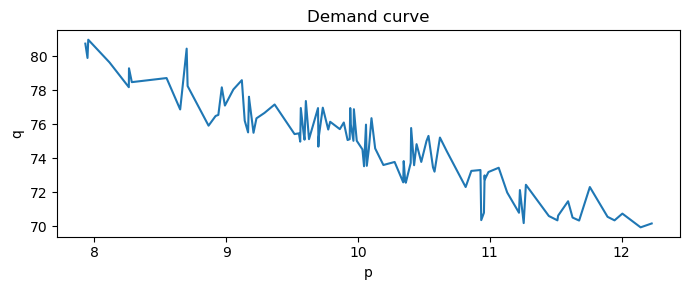

In [2]:
import matplotlib.pyplot as plt

f, a = plt.subplots(figsize=(7, 3))

df.set_index(['p'])['q'] \
    .plot(
        kind='line', 
        ax=a,
        title='Demand curve',
        ylabel='q'
    )

f.tight_layout()

## Modeling

We can model the demand curve with linear regression. The linear regression model of the demand curve is a straight line (it smooths out the empirical demand curve).

$Q \sim P$

In [3]:
from sklearn.linear_model import LinearRegression

X = df[['p']]
y = df['q']

qp_model = LinearRegression()
qp_model.fit(X, y)

qp_model.intercept_, qp_model.coef_

(99.20846337148424, array([-2.42286765]))

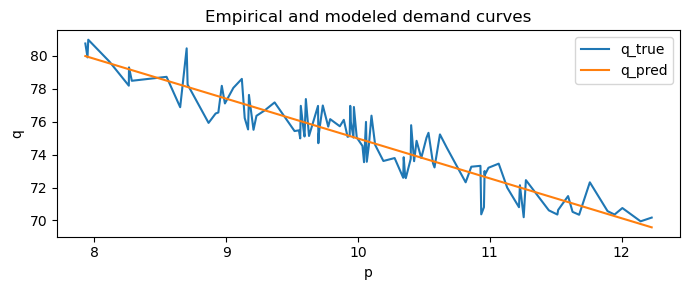

In [4]:
pred_df = df.assign(q_pred=qp_model.predict(X))

f, a = plt.subplots(figsize=(7, 3))

pred_df \
    .rename(columns={'q': 'q_true'}) \
    .set_index(['p']) \
    .plot(
        kind='line', 
        ax=a,
        title='Empirical and modeled demand curves',
        ylabel='q'
    )

f.tight_layout()

## Revenue optimization

From the linear regression model of the demand curve, we have the following relationships from the model.

- $Q = 99.20 - 2.42 P$
- $P = 40.99 - 0.41 Q$

We know the following about total revenue, $R$.

- $R = P Q$
- $R = \left(40.99 - 0.41 Q \right) Q$
- $R = 40.99 Q - 0.41 Q^2$

The marginal revenue is $R' = \dfrac{\mathrm{d} R}{\mathrm{d} Q}$.

- $R' = \dfrac{\mathrm{d} R}{\mathrm{d} Q} = 40.99 - 0.82 Q$

The marginal cost, $C'$, of producing a unit is (given as) 5.0. The optimal price can be found when we set $R' = C'$ and solve for $Q$ and plug back in $Q$ to get $P$.

- $R' = C'$
- $40.99 - 0.82 Q = 5.0$
- $-0.82 Q = -35.99$
- $Q = 43.89$

Since we know $P = 40.99 - 0.41 Q$, we plug $Q$ in to get the price. We can round $Q$ to 44.0.

- $P = 40.99 - 0.41 Q$
- $P = 40.99 - 0.41 (44.0)$
- $P = 22.95$

We can also compute $R = PQ$.

- $R = PQ$
- $R = 22.95 \times 44$
- $R = 1,009.80$

Let's define the profit, $T$, as follows, and plug in the values.

- $T = PQ - C'Q$
- $T = (22.95 \times 44) - (5 \times 44)$
- $T = 789.80$

In [16]:
def get_pq(b_0, b_1):
    return lambda q: (-b_0 / b_1) + (1 / b_1) * q

def get_qp(b_0, b_1):
    return lambda p: b_0 + (b_1 * p)

def get_mr(b_0, b_1):
    return lambda q: (-b_0 / b_1) + (2 * (1 / b_1) * q)

def get_qo(b_0, b_1):
    z_0 = (-b_0 / b_1)
    z_1 = 2 * (1 / b_1)
    return lambda mc: (mc - z_0) / z_1

def get_funcs(b_0, b_1):
    pq = get_pq(b_0, b_1)
    qp = get_qp(b_0, b_1)
    mr = get_mr(b_0, b_1)
    qo = get_qo(b_0, b_1)
    r = lambda p, q: p * q
    t = lambda p, q, mc: (p * q) - (mc * q)
    
    return pq, qp, mr, qo, r, t

def get_opt(f, mc):
    pq_f, qp_f, mr_f, qo_f, r_f, t_f = f
    
    q_opt = qo_f(mc)
    p_opt = pq_f(q_opt)
    mr_opt = mr_f(q_opt)
    r_opt = r_f(p_opt, q_opt)
    t_opt = t_f(p_opt, q_opt, mc)

    return pd.Series({
        'mc': mc,
        'q_opt': q_opt,
        'p_opt': p_opt,
        'mr_opt': mr_opt,
        'r_opt': r_opt,
        't_opt': t_opt
    })

f = get_funcs(qp_model.intercept_, qp_model.coef_[0])

In [17]:
get_opt(f, 5)

mc           5.000000
q_opt       43.547063
p_opt       22.973356
mr_opt       5.000000
r_opt     1000.422167
t_opt      782.686854
dtype: float64

<Axes: xlabel='p'>

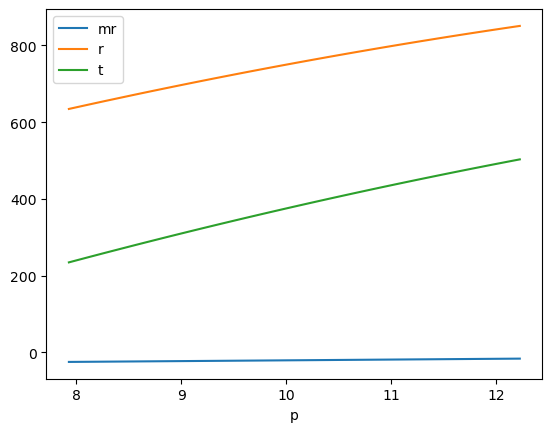

In [20]:
pred_df \
    .assign(
        mr=lambda d: f[2](d['q_pred']),
        r=lambda d: f[4](d['p'], d['q_pred']),
        t=lambda d: f[5](d['p'], d['q_pred'], 5)
    ) \
    .set_index(['p'])[['mr', 'r', 't']] \
    .plot(kind='line')